In [2]:
import torch
from torch import nn
from torchvision import datasets
from torchvision.transforms import ToTensor
from torchvision import transforms
from torch.utils.data import DataLoader
from torch import nn

In [3]:
# Flowers102 데이터셋 다운로드 및 로드
image_size = 225
train_data = datasets.Flowers102(
    root='data',
    split='train',
    transform = transforms.Compose([
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),]),
    download=True
)

# Flowers102 데이터셋 다운로드 및 로드 (테스트 데이터)
test_data = datasets.Flowers102(
    root='data',
    split='test',
    transform = transforms.Compose([
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),]),
    download=True
)

In [4]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [5]:
hyper_parameters = {}
hyper_parameters['batch_size'] = 64
hyper_parameters['epochs'] = 200
hyper_parameters['lr'] = 1e-4
hyper_parameters['weight_decay'] = 1e-3
hyper_parameters['loss_fn'] = nn.CrossEntropyLoss()

In [6]:
train_loader = DataLoader(train_data, batch_size=hyper_parameters['batch_size'], shuffle=True, num_workers=8)
test_loader = DataLoader(test_data, batch_size=hyper_parameters['batch_size'], shuffle=False, num_workers=8)

In [7]:
def train_loop(dataloader, model, loss_fn, optimizer, show_step = True):
    size = len(dataloader.dataset)
    model.train()
    ls = 0
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        pred = model(X)
        loss = loss_fn(pred, y)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        ls = loss.item()
        # if batch % 100 == 0 and show_step:
        #     loss, current = loss.item(), batch *32+len(X)
        #     print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    return ls

def test_loop(dataloader, model, loss_fn, show_step = True):
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    if show_step:
        print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return correct

In [8]:
def save_checkpoint(checkpoint, epoch, loss):
    torch.save({
        'model_state_dict': checkpoint.state_dict(),
        'optimizer_state_dict': hyper_parameters['optimizer'].state_dict(),
        'epoch': epoch,
        'loss': loss,
    }, f'./model/flower_102/flower102_{epoch}.pth')

In [9]:
def loop_epoch(epoch, train_loader, test_loader, model, loss_fn, optimizer, show_step):
    acc_history = []
    for t in range(epoch):
        if show_step:
            print(f"Epoch {t+1}\n-------------------------------")
        else:
            print(f"\r Epoch{t+1} running", end="")
        train_loop(train_loader, model, loss_fn, optimizer, show_step)
        acc = test_loop(test_loader, model, loss_fn, show_step)
        acc_history.append(acc)
        if t % 10 == 9:
            save_checkpoint(model, t, acc)
        plt.clf()
        plt.plot(range(1, t + 1), acc_history, marker='o')
        plt.title(f"Accuracy over epochs({hyper_parameters})")
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.grid(True)
        plt.show()
    print("Done!")
    return acc_history

In [10]:
class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()

        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=3, kernel_size=1, stride=1, padding=0) ,#224->224
            nn.MaxPool2d(kernel_size=3, stride=3),
            nn.ReLU(),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=6, kernel_size=3, stride=1, padding=1), #
            nn.MaxPool2d(kernel_size=3, stride=3),
            nn.ReLU(),
        )
        self.conv3 = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=3),#225->75
        )

        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=12, out_channels=24, kernel_size=3, stride=2, padding=1),#38
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),#19
        )

        self.linear_relu_stack = nn.Sequential(
            nn.Linear(in_features=19*19*24, out_features=19*24),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.BatchNorm1d(num_features=19*24),
            nn.Linear(in_features=24*19, out_features=102),
            nn.BatchNorm1d(num_features=102),
            nn.ReLU(),
            nn.Linear(in_features=102, out_features=102),
        )
    def forward(self, x):
        x1 = self.conv1(x)
        x2 = self.conv2(x)
        x3 = self.conv3(x)
        x = torch.cat((x1, x2, x3), 1)
        x = self.conv4(x)
        x = self.flatten(x)
        x = self.linear_relu_stack(x)
        return x
model = ConvNet().to(device)
hyper_parameters['optimizer'] = torch.optim.Adam(model.parameters(), lr=hyper_parameters['lr'], weight_decay=hyper_parameters['weight_decay'])

In [11]:
acc_history = loop_epoch(hyper_parameters['epochs'], train_loader, test_loader, model, hyper_parameters['loss_fn'], hyper_parameters['optimizer'], show_step=False)

 Epoch200 runningDone!


In [89]:
torch.save(model.state_dict(), "model/flower_102.pth")

In [12]:
from matplotlib import pyplot as plt

In [13]:
print(hyper_parameters)

{'batch_size': 64, 'epochs': 200, 'lr': 0.0001, 'weight_decay': 0.001, 'loss_fn': CrossEntropyLoss(), 'optimizer': Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.0001
    maximize: False
    weight_decay: 0.001
)}


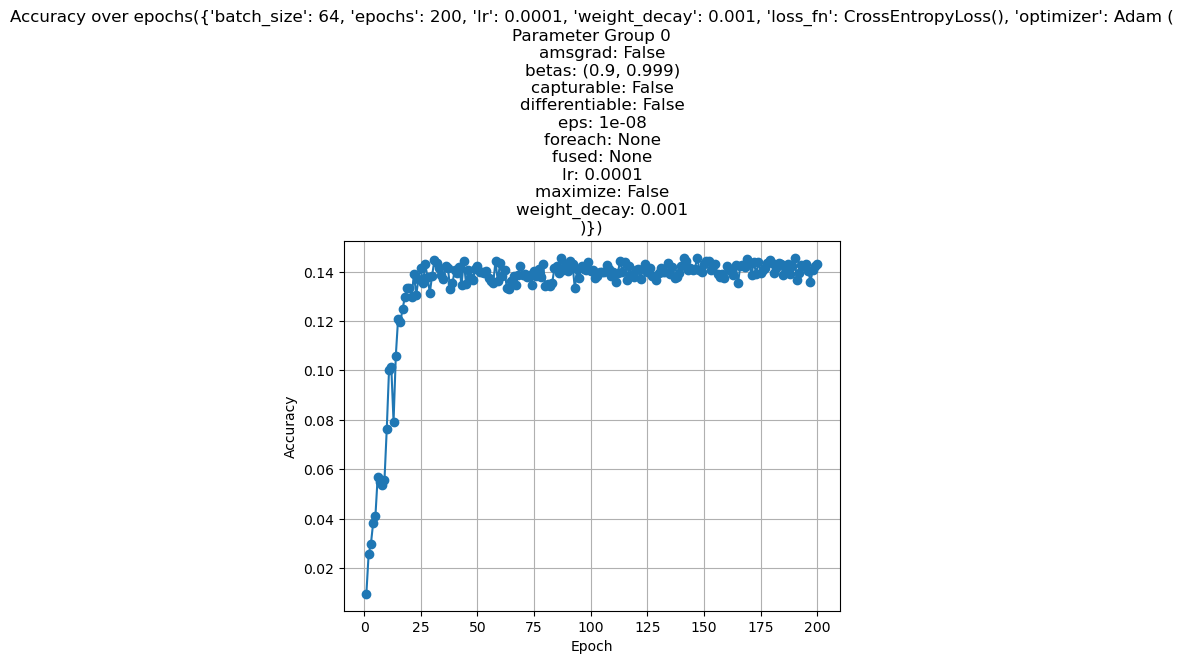

In [14]:
plt.plot(range(1, hyper_parameters['epochs'] + 1), acc_history, marker='o')
plt.title(f"Accuracy over epochs({hyper_parameters})")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()

In [88]:
print(max(acc_history))

0.12001951536835258
